# Policy/Pi-Value/Q-Adverserial/A gradients (PQA)


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [37]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [112]:
import numpy as np
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [113]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2')
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards2')
    return states, actions, rewards, rewards2, rewards3

In [114]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [115]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [116]:
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    # policy learning/gradient
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits,labels=actions_labels)        
    g_loss = tf.reduce_mean(-log_prob * rewards * rewards2 * rewards3)
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # rewards2
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits, 
                                                                    labels=tf.reshape(rewards, [-1, 1])))
    
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # rewards3
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                     labels=tf.reshape(rewards, shape=[-1, 1])))    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss

In [117]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [118]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [119]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [120]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

In [121]:
# Now train with experiences
saver = tf.train.Saver()

# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, g_loss_list, d_loss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    sess.run(tf.global_variables_initializer())
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action logits

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, rewards2_logits = sess.run([model.actions_logits, model.rewards2_logits],
                                                      feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += rewards2_logits[0, 0]
            rewards3_logits = sess.run(model.rewards3_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                         model.actions: np.array([action])})
            total_reward3 += rewards3_logits[0, 0]
            batch.append([state, action, reward, rewards2_logits[0, 0], rewards3_logits[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                                        feed_dict = {model.states: states, model.actions: actions,
                                                     model.rewards:rewards, model.rewards2:rewards2,
                                                     model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # For plotting
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pqa.ckpt')

Episode: 0 total_reward: 10.0 total_reward2: 5.2755 total_reward3: 5.2153 g_loss: -0.1789 d_loss: 1.2915
Episode: 1 total_reward: 47.0 total_reward2: 23.7101 total_reward3: 23.9282 g_loss: -0.1727 d_loss: 1.3595
Episode: 2 total_reward: 66.0 total_reward2: 32.9181 total_reward3: 33.6738 g_loss: -0.1736 d_loss: 1.3688
Episode: 3 total_reward: 40.0 total_reward2: 20.7982 total_reward3: 21.0508 g_loss: -0.1851 d_loss: 1.2960
Episode: 4 total_reward: 23.0 total_reward2: 12.0473 total_reward3: 12.1941 g_loss: -0.1884 d_loss: 1.2813
Episode: 5 total_reward: 21.0 total_reward2: 11.1915 total_reward3: 11.3471 g_loss: -0.1961 d_loss: 1.2450
Episode: 6 total_reward: 15.0 total_reward2: 8.0366 total_reward3: 8.2119 g_loss: -0.1997 d_loss: 1.2267
Episode: 7 total_reward: 13.0 total_reward2: 7.0480 total_reward3: 7.2612 g_loss: -0.2062 d_loss: 1.1949
Episode: 8 total_reward: 9.0 total_reward2: 4.9677 total_reward3: 5.1277 g_loss: -0.2134 d_loss: 1.1571
Episode: 9 total_reward: 9.0 total_reward2: 5.

Episode: 82 total_reward: 20.0 total_reward2: 19.7424 total_reward3: 19.7717 g_loss: -0.6733 d_loss: 0.0244
Episode: 83 total_reward: 54.0 total_reward2: 53.3744 total_reward3: 53.4606 g_loss: -0.6758 d_loss: 0.0217
Episode: 84 total_reward: 56.0 total_reward2: 55.4227 total_reward3: 55.5002 g_loss: -0.6769 d_loss: 0.0193
Episode: 85 total_reward: 10.0 total_reward2: 9.9299 total_reward3: 9.9365 g_loss: -0.6802 d_loss: 0.0134
Episode: 86 total_reward: 49.0 total_reward2: 48.5015 total_reward3: 48.5730 g_loss: -0.6771 d_loss: 0.0190
Episode: 87 total_reward: 42.0 total_reward2: 41.5976 total_reward3: 41.6562 g_loss: -0.6774 d_loss: 0.0178
Episode: 88 total_reward: 62.0 total_reward2: 61.3335 total_reward3: 61.4205 g_loss: -0.6768 d_loss: 0.0202
Episode: 89 total_reward: 61.0 total_reward2: 60.3596 total_reward3: 60.4495 g_loss: -0.6757 d_loss: 0.0196
Episode: 90 total_reward: 74.0 total_reward2: 73.3104 total_reward3: 73.3994 g_loss: -0.6786 d_loss: 0.0175
Episode: 91 total_reward: 40.0

Episode: 165 total_reward: 16.0 total_reward2: 15.9718 total_reward3: 15.9753 g_loss: -0.6883 d_loss: 0.0033
Episode: 166 total_reward: 26.0 total_reward2: 25.9432 total_reward3: 25.9509 g_loss: -0.6891 d_loss: 0.0041
Episode: 167 total_reward: 25.0 total_reward2: 24.9467 total_reward3: 24.9541 g_loss: -0.6888 d_loss: 0.0040
Episode: 168 total_reward: 35.0 total_reward2: 34.9256 total_reward3: 34.9331 g_loss: -0.6881 d_loss: 0.0040
Episode: 169 total_reward: 35.0 total_reward2: 34.9292 total_reward3: 34.9359 g_loss: -0.6872 d_loss: 0.0039
Episode: 170 total_reward: 19.0 total_reward2: 18.9634 total_reward3: 18.9669 g_loss: -0.6891 d_loss: 0.0037
Episode: 171 total_reward: 14.0 total_reward2: 13.9763 total_reward3: 13.9783 g_loss: -0.6893 d_loss: 0.0032
Episode: 172 total_reward: 20.0 total_reward2: 19.9652 total_reward3: 19.9682 g_loss: -0.6884 d_loss: 0.0033
Episode: 173 total_reward: 16.0 total_reward2: 15.9755 total_reward3: 15.9779 g_loss: -0.6894 d_loss: 0.0029
Episode: 174 total_

Episode: 247 total_reward: 16.0 total_reward2: 15.9879 total_reward3: 15.9894 g_loss: -0.6892 d_loss: 0.0014
Episode: 248 total_reward: 17.0 total_reward2: 16.9879 total_reward3: 16.9894 g_loss: -0.6892 d_loss: 0.0013
Episode: 249 total_reward: 20.0 total_reward2: 19.9866 total_reward3: 19.9876 g_loss: -0.6882 d_loss: 0.0013
Episode: 250 total_reward: 34.0 total_reward2: 33.9750 total_reward3: 33.9775 g_loss: -0.6900 d_loss: 0.0014
Episode: 251 total_reward: 52.0 total_reward2: 51.9614 total_reward3: 51.9662 g_loss: -0.6899 d_loss: 0.0014
Episode: 252 total_reward: 97.0 total_reward2: 96.9240 total_reward3: 96.9330 g_loss: -0.6888 d_loss: 0.0015
Episode: 253 total_reward: 24.0 total_reward2: 23.9813 total_reward3: 23.9836 g_loss: -0.6905 d_loss: 0.0015
Episode: 254 total_reward: 24.0 total_reward2: 23.9828 total_reward3: 23.9848 g_loss: -0.6902 d_loss: 0.0013
Episode: 255 total_reward: 38.0 total_reward2: 37.9660 total_reward3: 37.9697 g_loss: -0.6904 d_loss: 0.0017
Episode: 256 total_

Episode: 327 total_reward: 14.0 total_reward2: 13.9946 total_reward3: 13.9952 g_loss: -0.6908 d_loss: 0.0007
Episode: 328 total_reward: 13.0 total_reward2: 12.9942 total_reward3: 12.9950 g_loss: -0.6907 d_loss: 0.0008
Episode: 329 total_reward: 10.0 total_reward2: 9.9974 total_reward3: 9.9976 g_loss: -0.6902 d_loss: 0.0005
Episode: 330 total_reward: 37.0 total_reward2: 36.9824 total_reward3: 36.9845 g_loss: -0.6898 d_loss: 0.0009
Episode: 331 total_reward: 52.0 total_reward2: 51.9772 total_reward3: 51.9801 g_loss: -0.6897 d_loss: 0.0008
Episode: 332 total_reward: 89.0 total_reward2: 88.9718 total_reward3: 88.9751 g_loss: -0.6894 d_loss: 0.0006
Episode: 333 total_reward: 59.0 total_reward2: 58.9739 total_reward3: 58.9771 g_loss: -0.6897 d_loss: 0.0008
Episode: 334 total_reward: 49.0 total_reward2: 48.9772 total_reward3: 48.9800 g_loss: -0.6901 d_loss: 0.0009
Episode: 335 total_reward: 28.0 total_reward2: 27.9859 total_reward3: 27.9877 g_loss: -0.6900 d_loss: 0.0009
Episode: 336 total_re

Episode: 406 total_reward: 18.0 total_reward2: 17.9945 total_reward3: 17.9951 g_loss: -0.6907 d_loss: 0.0006
Episode: 407 total_reward: 20.0 total_reward2: 19.9943 total_reward3: 19.9950 g_loss: -0.6909 d_loss: 0.0005
Episode: 408 total_reward: 14.0 total_reward2: 13.9963 total_reward3: 13.9967 g_loss: -0.6912 d_loss: 0.0005
Episode: 409 total_reward: 10.0 total_reward2: 9.9980 total_reward3: 9.9982 g_loss: -0.6902 d_loss: 0.0004
Episode: 410 total_reward: 11.0 total_reward2: 10.9979 total_reward3: 10.9981 g_loss: -0.6901 d_loss: 0.0004
Episode: 411 total_reward: 10.0 total_reward2: 9.9980 total_reward3: 9.9982 g_loss: -0.6905 d_loss: 0.0004
Episode: 412 total_reward: 15.0 total_reward2: 14.9968 total_reward3: 14.9971 g_loss: -0.6909 d_loss: 0.0004
Episode: 413 total_reward: 16.0 total_reward2: 15.9960 total_reward3: 15.9964 g_loss: -0.6915 d_loss: 0.0005
Episode: 414 total_reward: 12.0 total_reward2: 11.9969 total_reward3: 11.9972 g_loss: -0.6917 d_loss: 0.0005
Episode: 415 total_rewa

Episode: 485 total_reward: 23.0 total_reward2: 22.9949 total_reward3: 22.9955 g_loss: -0.6920 d_loss: 0.0004
Episode: 486 total_reward: 47.0 total_reward2: 46.9894 total_reward3: 46.9906 g_loss: -0.6909 d_loss: 0.0004
Episode: 487 total_reward: 79.0 total_reward2: 78.9816 total_reward3: 78.9837 g_loss: -0.6919 d_loss: 0.0004
Episode: 488 total_reward: 53.0 total_reward2: 52.9876 total_reward3: 52.9887 g_loss: -0.6921 d_loss: 0.0004
Episode: 489 total_reward: 55.0 total_reward2: 54.9872 total_reward3: 54.9884 g_loss: -0.6922 d_loss: 0.0004
Episode: 490 total_reward: 53.0 total_reward2: 52.9880 total_reward3: 52.9890 g_loss: -0.6923 d_loss: 0.0004
Episode: 491 total_reward: 23.0 total_reward2: 22.9950 total_reward3: 22.9954 g_loss: -0.6924 d_loss: 0.0004
Episode: 492 total_reward: 30.0 total_reward2: 29.9937 total_reward3: 29.9941 g_loss: -0.6922 d_loss: 0.0004
Episode: 493 total_reward: 14.0 total_reward2: 13.9973 total_reward3: 13.9975 g_loss: -0.6924 d_loss: 0.0004
Episode: 494 total_

Episode: 563 total_reward: 20.0 total_reward2: 19.9973 total_reward3: 19.9976 g_loss: -0.6904 d_loss: 0.0003
Episode: 564 total_reward: 25.0 total_reward2: 24.9961 total_reward3: 24.9966 g_loss: -0.6911 d_loss: 0.0003
Episode: 565 total_reward: 20.0 total_reward2: 19.9969 total_reward3: 19.9973 g_loss: -0.6910 d_loss: 0.0003
Episode: 566 total_reward: 17.0 total_reward2: 16.9975 total_reward3: 16.9978 g_loss: -0.6899 d_loss: 0.0003
Episode: 567 total_reward: 16.0 total_reward2: 15.9982 total_reward3: 15.9983 g_loss: -0.6909 d_loss: 0.0002
Episode: 568 total_reward: 12.0 total_reward2: 11.9988 total_reward3: 11.9989 g_loss: -0.6910 d_loss: 0.0002
Episode: 569 total_reward: 13.0 total_reward2: 12.9987 total_reward3: 12.9988 g_loss: -0.6910 d_loss: 0.0002
Episode: 570 total_reward: 17.0 total_reward2: 16.9979 total_reward3: 16.9981 g_loss: -0.6912 d_loss: 0.0002
Episode: 571 total_reward: 13.0 total_reward2: 12.9987 total_reward3: 12.9989 g_loss: -0.6913 d_loss: 0.0002
Episode: 572 total_

Episode: 639 total_reward: 81.0 total_reward2: 80.9898 total_reward3: 80.9908 g_loss: -0.6921 d_loss: 0.0002
Episode: 640 total_reward: 55.0 total_reward2: 54.9931 total_reward3: 54.9938 g_loss: -0.6921 d_loss: 0.0002
Episode: 641 total_reward: 64.0 total_reward2: 63.9918 total_reward3: 63.9927 g_loss: -0.6922 d_loss: 0.0002
Episode: 642 total_reward: 44.0 total_reward2: 43.9945 total_reward3: 43.9950 g_loss: -0.6923 d_loss: 0.0002
Episode: 643 total_reward: 258.0 total_reward2: 257.9682 total_reward3: 257.9707 g_loss: -0.6924 d_loss: 0.0002
Episode: 644 total_reward: 26.0 total_reward2: 25.9968 total_reward3: 25.9972 g_loss: -0.6925 d_loss: 0.0002
Episode: 645 total_reward: 56.0 total_reward2: 55.9932 total_reward3: 55.9938 g_loss: -0.6922 d_loss: 0.0002
Episode: 646 total_reward: 57.0 total_reward2: 56.9932 total_reward3: 56.9939 g_loss: -0.6921 d_loss: 0.0002
Episode: 647 total_reward: 37.0 total_reward2: 36.9959 total_reward3: 36.9963 g_loss: -0.6919 d_loss: 0.0002
Episode: 648 tot

Episode: 715 total_reward: 500.0 total_reward2: 499.9508 total_reward3: 499.9547 g_loss: -0.6927 d_loss: 0.0002
Episode: 716 total_reward: 73.0 total_reward2: 72.9932 total_reward3: 72.9938 g_loss: -0.6923 d_loss: 0.0002
Episode: 717 total_reward: 11.0 total_reward2: 10.9995 total_reward3: 10.9995 g_loss: -0.6917 d_loss: 0.0001
Episode: 718 total_reward: 500.0 total_reward2: 499.9504 total_reward3: 499.9548 g_loss: -0.6929 d_loss: 0.0002
Episode: 719 total_reward: 52.0 total_reward2: 51.9950 total_reward3: 51.9954 g_loss: -0.6928 d_loss: 0.0002
Episode: 720 total_reward: 42.0 total_reward2: 41.9961 total_reward3: 41.9964 g_loss: -0.6927 d_loss: 0.0002
Episode: 721 total_reward: 12.0 total_reward2: 11.9993 total_reward3: 11.9993 g_loss: -0.6927 d_loss: 0.0001
Episode: 722 total_reward: 9.0 total_reward2: 8.9995 total_reward3: 8.9995 g_loss: -0.6929 d_loss: 0.0001
Episode: 723 total_reward: 500.0 total_reward2: 499.9506 total_reward3: 499.9553 g_loss: -0.6929 d_loss: 0.0002
Episode: 724 

Episode: 793 total_reward: 52.0 total_reward2: 51.9960 total_reward3: 51.9964 g_loss: -0.6926 d_loss: 0.0001
Episode: 794 total_reward: 65.0 total_reward2: 64.9947 total_reward3: 64.9952 g_loss: -0.6928 d_loss: 0.0002
Episode: 795 total_reward: 189.0 total_reward2: 188.9849 total_reward3: 188.9864 g_loss: -0.6926 d_loss: 0.0002
Episode: 796 total_reward: 71.0 total_reward2: 70.9955 total_reward3: 70.9959 g_loss: -0.6916 d_loss: 0.0001
Episode: 797 total_reward: 62.0 total_reward2: 61.9962 total_reward3: 61.9965 g_loss: -0.6912 d_loss: 0.0001
Episode: 798 total_reward: 31.0 total_reward2: 30.9976 total_reward3: 30.9979 g_loss: -0.6920 d_loss: 0.0001
Episode: 799 total_reward: 27.0 total_reward2: 26.9980 total_reward3: 26.9982 g_loss: -0.6915 d_loss: 0.0001
Episode: 800 total_reward: 24.0 total_reward2: 23.9982 total_reward3: 23.9984 g_loss: -0.6916 d_loss: 0.0001
Episode: 801 total_reward: 18.0 total_reward2: 17.9989 total_reward3: 17.9990 g_loss: -0.6908 d_loss: 0.0001
Episode: 802 tot

Episode: 874 total_reward: 14.0 total_reward2: 13.9992 total_reward3: 13.9993 g_loss: -0.6901 d_loss: 0.0001
Episode: 875 total_reward: 13.0 total_reward2: 12.9993 total_reward3: 12.9994 g_loss: -0.6905 d_loss: 0.0001
Episode: 876 total_reward: 17.0 total_reward2: 16.9991 total_reward3: 16.9992 g_loss: -0.6907 d_loss: 0.0001
Episode: 877 total_reward: 16.0 total_reward2: 15.9992 total_reward3: 15.9993 g_loss: -0.6909 d_loss: 0.0001
Episode: 878 total_reward: 12.0 total_reward2: 11.9995 total_reward3: 11.9996 g_loss: -0.6885 d_loss: 0.0001
Episode: 879 total_reward: 15.0 total_reward2: 14.9994 total_reward3: 14.9995 g_loss: -0.6901 d_loss: 0.0001
Episode: 880 total_reward: 14.0 total_reward2: 13.9995 total_reward3: 13.9995 g_loss: -0.6895 d_loss: 0.0001
Episode: 881 total_reward: 13.0 total_reward2: 12.9995 total_reward3: 12.9995 g_loss: -0.6907 d_loss: 0.0001
Episode: 882 total_reward: 10.0 total_reward2: 9.9996 total_reward3: 9.9997 g_loss: -0.6904 d_loss: 0.0001
Episode: 883 total_re

Episode: 949 total_reward: 145.0 total_reward2: 144.9920 total_reward3: 144.9928 g_loss: -0.6928 d_loss: 0.0001
Episode: 950 total_reward: 109.0 total_reward2: 108.9939 total_reward3: 108.9945 g_loss: -0.6928 d_loss: 0.0001
Episode: 951 total_reward: 85.0 total_reward2: 84.9953 total_reward3: 84.9957 g_loss: -0.6929 d_loss: 0.0001
Episode: 952 total_reward: 64.0 total_reward2: 63.9966 total_reward3: 63.9969 g_loss: -0.6928 d_loss: 0.0001
Episode: 953 total_reward: 55.0 total_reward2: 54.9971 total_reward3: 54.9973 g_loss: -0.6928 d_loss: 0.0001
Episode: 954 total_reward: 46.0 total_reward2: 45.9976 total_reward3: 45.9978 g_loss: -0.6928 d_loss: 0.0001
Episode: 955 total_reward: 31.0 total_reward2: 30.9985 total_reward3: 30.9986 g_loss: -0.6928 d_loss: 0.0001
Episode: 956 total_reward: 43.0 total_reward2: 42.9980 total_reward3: 42.9981 g_loss: -0.6926 d_loss: 0.0001
Episode: 957 total_reward: 16.0 total_reward2: 15.9993 total_reward3: 15.9994 g_loss: -0.6928 d_loss: 0.0001
Episode: 958 

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total env rewards')

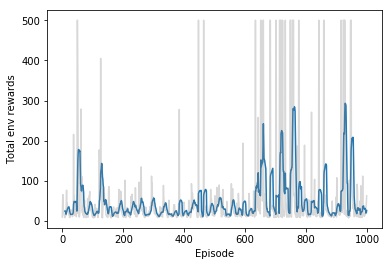

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

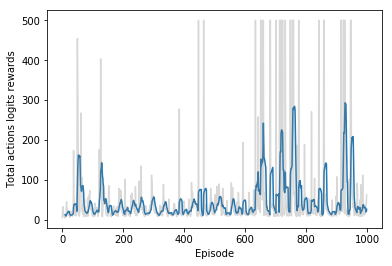

In [127]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Gloss')

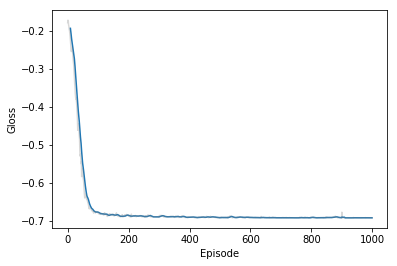

In [128]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

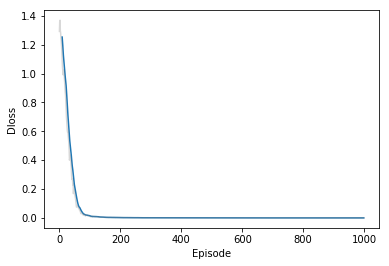

In [129]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')